In [1]:
import pandas as pd
import numpy as np
import re

### 데이터 불러오기

In [2]:
scoreDF1 = pd.read_csv('가치점수.csv')
scoreDF2 = pd.read_csv('가중치가치점수.csv')

In [3]:
cleanDF = pd.read_csv('../data/finalNews.csv', index_col=0)
def remove_special_characters_except_korean(text, exceptions):

    box = ['재배포 금지','무단 전재', '무단전재' "기자", "뉴스"]
    
    # box 안의 내용 삭제
    for i in box:
        text = text.replace(i, '')

    # exceptions에 포함된 특수문자와 한글을 제외하고 모든 특수문자를 제거하는 정규식 패턴
    pattern = re.compile(f'[^ㄱ-ㅎ가-힣0-9{re.escape(exceptions)}]')

    # 정규식을 사용하여 특수문자 제거
    result = re.sub(pattern, ' ', text)

    # 언론사명 삭제
    for i in cleanDF['언론사'].unique():
        result = result.replace(i, '')

    return result

In [4]:
# cleanDF['제목'] = cleanDF['제목'].apply(lambda x: remove_special_characters_except_korean(x, '~%.'))
# cleanDF[['제목','본문']].to_csv('신뢰도분석파일1.csv', index=False)

In [5]:
cleanDF = cleanDF.dropna(subset=['본문'])[['제목','본문']]
scoreDF1 = scoreDF1[scoreDF1.index.isin(cleanDF.index)]
scoreDF2 = scoreDF2[scoreDF2.index.isin(cleanDF.index)]

In [6]:
# 갯수 확인
len(cleanDF),len(scoreDF1), len(scoreDF2)

(39946, 39946, 39946)

In [7]:
# cleanDF.to_csv('cleanDF.csv')
# scoreDF1.to_csv('가중치점수1.csv')
# scoreDF2.to_csv('가중치가치점수1.csv')

### 신뢰도 타겟 좋음, 중간, 나쁨 생성

In [8]:
import matplotlib.pyplot as plt

In [9]:
scoreDF1.describe()

,0
count,39946.000000
mean,14.065121
std,14.599650
min,-18.000000
25%,8.000000
50%,10.000000
75%,14.455000
max,147.500000


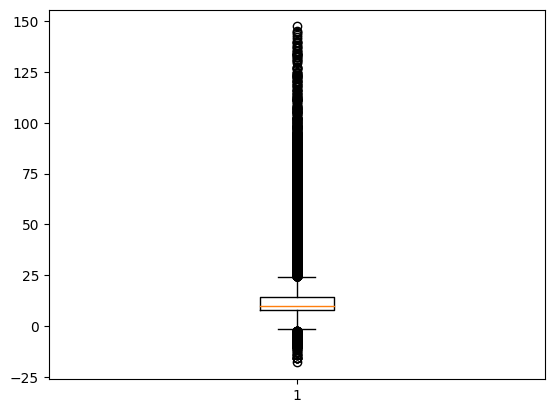

In [10]:
plt.boxplot(scoreDF1)
plt.show()

- 3사분위수보다 많으면 신뢰도 좋음 : 2
- 1사위분수 - 1.5IQR 이상 3사위분수 미만이면 신뢰도 중간 : 1
- 1사위분수 - 1.5IQR미만 신뢰도 나쁨 : 0

In [11]:
q3 = np.percentile(scoreDF1,75)
q1 = np.percentile(scoreDF1,25)

In [12]:
scoreDF1['0']=scoreDF1['0'].apply(lambda x: 2 if x >= q3 else 1 if x >= q1 else 0)

In [13]:
scoreDF2.describe()

,0
count,39946.000000
mean,44.843125
std,43.432122
min,-45.903000
25%,25.964800
50%,32.456000
75%,45.459000
max,438.536000


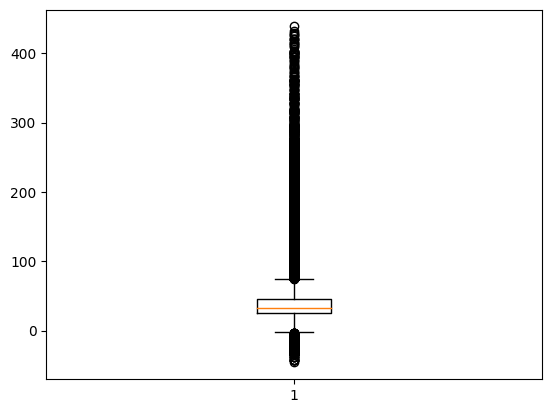

In [14]:
plt.boxplot(scoreDF2)
plt.show()

- 3사분위수보다 많으면 신뢰도 좋음 : 2
- 1사위분수 - 1.5IQR 이상 3사위분수 미만이면 신뢰도 중간 : 1
- 1사위분수 - 1.5IQR미만 신뢰도 나쁨 : 0

In [15]:
q3 = np.percentile(scoreDF2,75)
q1 = np.percentile(scoreDF2,25)

In [16]:
scoreDF2['0']=scoreDF2['0'].apply(lambda x: 2 if x >= q3 else 1 if x >= q1 else 0)

In [17]:
# 타겟생성
scoreDF = scoreDF2['0'] + scoreDF1['0']
scoreDF = scoreDF/2
scoreDF = scoreDF.apply(lambda x : 2 if x == 2 else 1 if x >=1 else 0)

## 토큰화

In [18]:
from sklearn.model_selection import train_test_split
trainX, testX, trainy, testy = train_test_split(cleanDF[['제목','본문']], scoreDF, test_size= 0.3, random_state= 42, stratify=scoreDF)

In [19]:
# 토큰화, 벡터화
from keras import preprocessing
from keras.utils import pad_sequences

vocab_size = 1000
max_sequence_length = 100
# num_words에 지정된 만큼만 숫자로 반환, 나머지는 0으로 반환
tokenizer = preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<oov>")    # oov_tok을 사용하여 사전에 없는 단어집합을 만듬
tokenizer.fit_on_texts(trainX['제목'])


title_train_sequences = tokenizer.texts_to_sequences(trainX['제목'])
title_train_padded = pad_sequences(title_train_sequences, maxlen=max_sequence_length)
title_test_sequences = tokenizer.texts_to_sequences(testX['제목'])
title_test_padded = pad_sequences(title_test_sequences, maxlen=max_sequence_length)


tokenizer.fit_on_texts(trainX['본문'])
body_train_sequences = tokenizer.texts_to_sequences(trainX['본문'])
body_train_padded = pad_sequences(body_train_sequences, maxlen=max_sequence_length)
body_test_sequences = tokenizer.texts_to_sequences(testX['본문'])
body_test_padded = pad_sequences(body_test_sequences, maxlen=max_sequence_length)

In [20]:
# 범주화 원핫인코딩
import tensorflow as tf
from keras.utils import to_categorical
# Assuming trainy and testy are categorical labels (0, 1, 2 for example)
trainy_one_hot = to_categorical(trainy, num_classes=3)
testy_one_hot = to_categorical(testy, num_classes=3)

## 모델

In [21]:
from keras.layers import Input, Embedding, LSTM, concatenate, Dense, Dropout
from keras.models import Model

max_sequence_length = 100
# Define input layers
title_input = Input(shape=(max_sequence_length,))
body_input = Input(shape=(max_sequence_length,))

# Shared embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=64, input_length=max_sequence_length)

# Apply the embedding layer to both inputs
title_embedding = embedding_layer(title_input)
body_embedding = embedding_layer(body_input)

# Apply LSTM to each input
title_lstm = LSTM(64, activation='relu', return_sequences=True)(title_embedding)
title_lstm = LSTM(64, activation='relu')(title_lstm)

body_lstm = LSTM(64, activation='relu', return_sequences=True)(body_embedding)
body_lstm = LSTM(64, activation='relu')(body_lstm)

# Concatenate the outputs
merged = concatenate([title_lstm, body_lstm])

# Apply Dropout
merged = Dropout(0.4)(merged)  # You can adjust the dropout rate as needed

# Additional Dense layer
merged = Dense(64, activation='relu')(merged)

# Output layer
output_layer = Dense(3, activation='softmax')(merged)

# Create the model
model = Model(inputs=[title_input, body_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 64)              64000     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 100, 64)              33024     ['embedding[0][0]']       

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.005,
    mode='min',  # The indicator must decrease to be considered the best model
    verbose=1,
    restore_best_weights=True
)

# Fit the model with callbacks
history = model.fit(
    [title_train_padded, body_train_padded],
    trainy_one_hot,
    epochs=200,  # You can adjust the number of epochs
    batch_size=100,  # You can adjust the batch size
    validation_data=([title_test_padded, body_test_padded], testy_one_hot),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/200
280/280 [==============================] - 80s 271ms/step - loss: 344193.3750 - accuracy: 0.6850 - val_loss: 0.7073 - val_accuracy: 0.6839
Epoch 2/200


C:\Users\LG\anaconda3\envs\daegu\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/280 [==============================] - 91s 325ms/step - loss: 4252803.0000 - accuracy: 0.6889 - val_loss: 0.7095 - val_accuracy: 0.6847
Epoch 3/200
280/280 [==============================] - 134s 480ms/step - loss: 0.6988 - accuracy: 0.6862 - val_loss: 0.7000 - val_accuracy: 0.6856
Epoch 4/200
280/280 [==============================] - 129s 462ms/step - loss: 0.6898 - accuracy: 0.6856 - val_loss: 0.6902 - val_accuracy: 0.6889
Epoch 5/200
280/280 [==============================] - 126s 451ms/step - loss: 0.6808 - accuracy: 0.6881 - val_loss: 0.6848 - val_accuracy: 0.6931
Epoch 6/200
280/280 [==============================] - 113s 402ms/step - loss: 0.6740 - accuracy: 0.6909 - val_loss: 0.6837 - val_accuracy: 0.6885
Epoch 7/200
280/280 [==============================] - 107s 382ms/step - loss: 0.6666 - accuracy: 0.6919 - val_loss: 0.6777 - val_accuracy: 0.6943
Epoch 8/200
280/280 [==============================] - 128s 456ms/step - loss: 0.6599 - accuracy: 0.6943 - val_loss: 0.6754 -

In [24]:
from keras.layers import Input, Embedding, LSTM, concatenate, Dense, Dropout
from keras.models import Model

max_sequence_length = 100
# Define input layers
title_input = Input(shape=(max_sequence_length,))
body_input = Input(shape=(max_sequence_length,))

# Shared embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=64, input_length=max_sequence_length)

# Apply the embedding layer to both inputs
title_embedding = embedding_layer(title_input)
body_embedding = embedding_layer(body_input)

# Apply LSTM to each input
title_lstm = LSTM(64, activation='relu', return_sequences=True)(title_embedding)
title_lstm = LSTM(64, activation='relu')(title_lstm)

body_lstm = LSTM(64, activation='relu', return_sequences=True)(body_embedding)
body_lstm = LSTM(64, activation='relu')(body_lstm)

# Concatenate the outputs
merged = concatenate([title_lstm, body_lstm])

# Apply Dropout
merged = Dropout(0.4)(merged)  # You can adjust the dropout rate as needed

# Additional Dense layer
merged = Dense(64, activation='relu')(merged)

# Output layer
output_layer = Dense(1, activation='softmax')(merged)

# Create the model
model_lstm = Model(inputs=[title_input, body_input], outputs=output_layer)

# Compile the model
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model_lstm.summary()